In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('kenya_tripadvisor_data_1.csv')
df1.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [3]:
df2 = df1.copy()
df2.head()

,Destination Name,Destination Type,Rating,Review Head,Review Body,Date
0,Giraffe Centre,Nature/Parks,5,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,June 2017
1,Giraffe Centre,Nature/Parks,4,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,December 2016
2,Giraffe Centre,Nature/Parks,3,Close to the giraffes,You get to come very close to the giraffes. Yo...,June 2017
3,Giraffe Centre,Nature/Parks,5,Giraffe kiss!,If you like giraffes you'll love this place. E...,June 2017
4,Giraffe Centre,Nature/Parks,5,A wonderful moment in time.,We always visit this attraction each and every...,June 2017


In [4]:
from nltk import tokenize

df2.drop('Rating', axis = 1, inplace = True)
df2.drop('Date', axis = 1, inplace = True)
df2['Review Head'] = df2['Review Head'].apply(lambda x: re.sub('\s+', ' ', x))
df2['Review Body'] = df2['Review Body'].apply(lambda x: re.sub('\s+', ' ', x))
df2['RB_Sentence1'] = df2['Review Body'].apply(lambda x: tokenize.sent_tokenize(x)[0])
df2['RH_Split'] = df2['Review Head'].apply(lambda x: x.split(' '))
df2['RB_Split'] = df2['Review Body'].apply(lambda x: x.split(' '))
df2['RB_Sentence1_Split'] = df2['RB_Sentence1'].apply(lambda x: x.split(' '))
df2['TextBlob Polarity Head'] = df2['Review Head'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity Body'] = df2['Review Body'].map(lambda text: TextBlob(text).sentiment.polarity)
df2['TextBlob Polarity RBS1'] = df2['RB_Sentence1'].map(lambda text: TextBlob(text).sentiment.polarity)

In [5]:
df2.head()

,Destination Name,Destination Type,Review Head,Review Body,RB_Sentence1,RH_Split,RB_Split,RB_Sentence1_Split,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity RBS1
0,Giraffe Centre,Nature/Parks,Giraffes and Baby Elephants!,If you find yourself with a day in Nairobi bef...,If you find yourself with a day in Nairobi bef...,"[Giraffes, and, Baby, Elephants!]","[If, you, find, yourself, with, a, day, in, Na...","[If, you, find, yourself, with, a, day, in, Na...",0.0,0.160000,0.16
1,Giraffe Centre,Nature/Parks,Places to visit in Karen - Giraffe Centre,A fun place to visit - you not only get to fee...,A fun place to visit - you not only get to fee...,"[Places, to, visit, in, Karen, -, Giraffe, Cen...","[A, fun, place, to, visit, -, you, not, only, ...","[A, fun, place, to, visit, -, you, not, only, ...",0.0,0.450000,0.15
2,Giraffe Centre,Nature/Parks,Close to the giraffes,You get to come very close to the giraffes. Yo...,You get to come very close to the giraffes.,"[Close, to, the, giraffes]","[You, get, to, come, very, close, to, the, gir...","[You, get, to, come, very, close, to, the, gir...",0.0,0.100000,0.20
3,Giraffe Centre,Nature/Parks,Giraffe kiss!,If you like giraffes you'll love this place. E...,If you like giraffes you'll love this place.,"[Giraffe, kiss!]","[If, you, like, giraffes, you'll, love, this, ...","[If, you, like, giraffes, you'll, love, this, ...",0.0,0.200000,0.50
4,Giraffe Centre,Nature/Parks,A wonderful moment in time.,We always visit this attraction each and every...,We always visit this attraction each and every...,"[A, wonderful, moment, in, time.]","[We, always, visit, this, attraction, each, an...","[We, always, visit, this, attraction, each, an...",1.0,0.214286,0.00


In [6]:
df2['Destination Type'].value_counts()

Nature/Parks    21143
Museums          4685
Landmarks        3307
Name: Destination Type, dtype: int64

### Topic Modelling

In [7]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df2['RH_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list))

Positive : 16736
Neutral : 112476
Negative : 618


In [8]:
from nltk.corpus import stopwords

# main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
#                        'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
#                        'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
#                        'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
#                        '\n', '‘s']

main_stop_words = ['kenya', 'kenyan', 'africa', 'african', 'church', 'churches', 'park', 'parks', 'museum', 'museums',
                   'lamu', 'valley', 'mountain', 'mountains', 'national', 'nairobi', 'amboseli'  
                   'cathedral', 'cathedrals', 'place', 'visit', 'site', 'town',  
                   '\n', '‘s']

positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1493


In [9]:
# Convert to list
data = df2[df2['Destination Type'] == 'Nature/Parks'][df2['TextBlob Polarity Head'] > 0]['Review Head'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['A wonderful moment in time.']


In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['wonderful', 'moment', 'in', 'time']]


In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['wonderful', 'moment', 'in', 'time']


In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['moment', 'time']]


In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [15]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('moment', 1), ('time', 1)]]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [17]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.344*"experience" + 0.148*"elephant" + 0.074*"baby" + 0.023*"unique" + '
  '0.018*"first" + 0.018*"unforgettable" + 0.016*"family" + 0.015*"orphan" + '
  '0.015*"simply" + 0.015*"stop"'),
 (1,
  '0.208*"worth" + 0.107*"work" + 0.055*"nature" + 0.045*"get" + 0.043*"crowd" '
  '+ 0.036*"early" + 0.032*"rhino" + 0.024*"do" + 0.023*"want" + 0.020*"live"'),
 (2,
  '0.117*"walk" + 0.086*"giraffe" + 0.081*"feed" + 0.063*"visit" + '
  '0.049*"conservation" + 0.039*"hot" + 0.026*"crowded" + 0.026*"part" + '
  '0.025*"busy" + 0.022*"action"'),
 (3,
  '0.077*"child" + 0.057*"chance" + 0.047*"highlight" + 0.043*"back" + '
  '0.026*"night" + 0.024*"drop" + 0.022*"preserve" + 0.021*"gift" + '
  '0.018*"adult" + 0.017*"adopt"'),
 (4,
  '0.201*"animal" + 0.150*"close" + 0.097*"view" + 0.051*"much" + '
  '0.036*"stunning" + 0.031*"spot" + 0.027*"learn" + 0.024*"take" + '
  '0.023*"game" + 0.020*"high"'),
 (5,
  '0.098*"many" + 0.097*"time" + 0.042*"world" + 0.037*"flamingo" + '
  '0.036*"natur

In [18]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.955206062036588

Coherence Score:  0.6309225720519132


In [19]:
# # Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [20]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word, random_seed=1)

In [21]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('city', 0.12544547398431932),
   ('feed', 0.07697790449037777),
   ('giraffe', 0.07555238774055595),
   ('magical', 0.042765502494654314),
   ('crowd', 0.039201710620099785),
   ('conservation', 0.03848895224518888),
   ('spot', 0.036350677120456164),
   ('real', 0.036350677120456164),
   ('small', 0.03349964362081254),
   ('busy', 0.027797576621525304)]),
 (1,
  [('elephant', 0.4499654934437543),
   ('baby', 0.2180814354727398),
   ('orphan', 0.05452035886818495),
   ('project', 0.014492753623188406),
   ('chance', 0.013112491373360938),
   ('effort', 0.012422360248447204),
   ('orphaned', 0.010351966873706004),
   ('ellie', 0.00966183574879227),
   ('scenic', 0.008971704623878536),
   ('play', 0.00759144237405107)]),
 (2,
  [('animal', 0.2630844382414515),
   ('walk', 0.12212142358688068),
   ('nature', 0.045359385903698535),
   ('watch', 0.03838101884159107),
   ('bird', 0.034891835310537335),
   ('full', 0.03210048848569435),
   ('unique', 0.02930914166085136),
   ('hippos

2
3
4
5
6
7
8
9
10


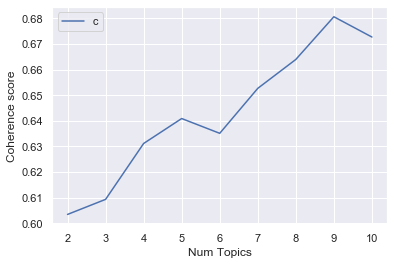

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word,
                                                random_seed=1)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6035
Num Topics = 3  has Coherence Value of 0.6093
Num Topics = 4  has Coherence Value of 0.6312
Num Topics = 5  has Coherence Value of 0.6409
Num Topics = 6  has Coherence Value of 0.6351
Num Topics = 7  has Coherence Value of 0.6527
Num Topics = 8  has Coherence Value of 0.664
Num Topics = 9  has Coherence Value of 0.6806
Num Topics = 10  has Coherence Value of 0.6727


In [24]:
optimal_model = model_list[7] # Number of Topics = 9

# optimal_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=7, id2word=id2word)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.213*"close" + 0.107*"work" + 0.066*"giraffe" + 0.052*"kid" + '
  '0.050*"stunning" + 0.043*"city" + 0.025*"family" + 0.025*"water" + '
  '0.024*"personal" + 0.024*"creature"'),
 (1,
  '0.223*"animal" + 0.112*"wild" + 0.056*"life" + 0.039*"early" + '
  '0.037*"magical" + 0.023*"scenery" + 0.021*"memorable" + 0.020*"drive" + '
  '0.019*"forest" + 0.018*"stay"'),
 (2,
  '0.154*"experience" + 0.150*"day" + 0.042*"short" + 0.039*"thing" + '
  '0.038*"world" + 0.038*"cool" + 0.030*"informative" + 0.024*"animal" + '
  '0.023*"top" + 0.020*"conservancy"'),
 (3,
  '0.342*"experience" + 0.071*"view" + 0.067*"feed" + 0.053*"hour" + '
  '0.037*"spend" + 0.020*"learn" + 0.015*"large" + 0.013*"crowd" + '
  '0.012*"sight" + 0.011*"effort"'),
 (4,
  '0.068*"city" + 0.062*"beach" + 0.059*"view" + 0.047*"lot" + 0.042*"game" + '
  '0.042*"tour" + 0.042*"educational" + 0.035*"watch" + 0.032*"bird" + '
  '0.031*"absolutely"'),
 (5,
  '0.412*"elephant" + 0.199*"baby" + 0.050*"orphan" + 0.029*"peop

In [25]:
optimal_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model2, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.141457  0.235291       1        1  11.166385
1     -0.100456  0.007123       2        1  11.157705
0     -0.183678 -0.267898       3        1  11.143441
7     -0.141034  0.097850       4        1  11.130460
4     -0.145264 -0.257979       5        1  11.126799
6     -0.128391  0.219480       6        1  11.102648
3      0.293760 -0.029721       7        1  11.076420
8      0.306427 -0.014732       8        1  11.059753
2      0.240092  0.010585       9        1  11.036389, topic_info=     Category         Freq         Term        Total  loglift  logprob
8     Default  1520.000000   experience  1520.000000  30.0000  30.0000
4     Default   761.000000     elephant   761.000000  29.0000  29.0000
15    Default   393.000000        close   393.000000  28.0000  28.0000
11    Default   454.000000       animal   454.000000  27.0000  27.0000
54    Default   369.000000        worth   369.000000  26.0000  26.0000
3     Default   370.000000         baby   370.000000  25.0000  25.0000
10    Default   301.000000     wildlife   301.000000  24.0000  24.0000
141   Default   274.000000          day   274.000000  23.0000  23.0000
17    Default   254.000000         trip   254.000000  22.0000  22.0000
1     Default   227.000000         time   227.000000  21.0000  21.0000
68    Default   207.000000         wild   207.000000  20.0000  20.0000
9     Default   204.000000         walk   204.000000  19.0000  19.0000
113   Default   200.000000         work   200.000000  18.0000  18.0000
57    Default   239.000000         view   239.000000  17.0000  17.0000
170   Default   204.000000         city   204.000000  16.0000  16.0000
6     Default   138.000000   incredible   138.000000  15.0000  15.0000
46    Default   122.000000         feed   122.000000  14.0000  14.0000
129   Default   121.000000      giraffe   121.000000  13.0000  13.0000
105   Default   114.000000        beach   114.000000  12.0000  12.0000
194   Default   104.000000         life   104.000000  11.0000  11.0000
119   Default    96.000000         hour    96.000000  10.0000  10.0000
121   Default    95.000000          kid    95.000000   9.0000   9.0000
99    Default    92.000000     stunning    92.000000   8.0000   8.0000
184   Default    92.000000       orphan    92.000000   7.0000   7.0000
13    Default    90.000000       unique    90.000000   6.0000   6.0000
48    Default    85.000000          lot    85.000000   5.0000   5.0000
155   Default    78.000000        visit    78.000000   4.0000   4.0000
72    Default    77.000000         tour    77.000000   3.0000   3.0000
188   Default    77.000000         game    77.000000   2.0000   2.0000
87    Default    75.000000       nature    75.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
203    Topic9    29.573653         half    29.573653   2.2040  -4.1238
178    Topic9    27.109182        price    27.109182   2.2040  -4.2108
171    Topic9    27.109182    excursion    27.109182   2.2040  -4.2108
329    Topic9    27.109182          job    27.109182   2.2040  -4.2108
319    Topic9    20.948004   wilderness    20.948004   2.2040  -4.4686
707    Topic9    20.948004  destination    20.948004   2.2040  -4.4686
152    Topic9    76.398604        short    77.535545   2.1892  -3.1747
216    Topic9    14.786827          age    14.786827   2.2040  -4.8169
88     Topic9    14.786827      refresh    14.786827   2.2040  -4.8169
197    Topic9     9.857884     endanger     9.857884   2.2040  -5.2224
697    Topic9     7.393413     surprise     7.393413   2.2040  -5.5101
115    Topic9     7.393413       decent     7.393413   2.2040  -5.5101
771    Topic9     6.161178        hippo     6.161178   2.2040  -5.6924
308    Topic9     6.161178     outdoors     6.161178   2.2040  -5.6924
295    Topic9     6.161178     maintain     6.161178   2.2040  -5.6924
1227   Topic9     4.928942

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1261,"city, beach, view, lot, game, tour, educationa...",A wonderful moment in time.
1,1,0.0,0.1111,"close, work, giraffe, kid, stunning, city, fam...",Great fun
2,2,0.0,0.1111,"close, work, giraffe, kid, stunning, city, fam...",Fun place to visit
3,3,0.0,0.1264,"close, work, giraffe, kid, stunning, city, fam...",Great family place
4,4,5.0,0.1453,"elephant, baby, orphan, people, crowd, young, ...",Okay--who doesnt love a baby elephant
5,5,7.0,0.1285,"wildlife, incredible, morning, spot, conservat...",Amazing morning
6,6,0.0,0.1111,"close, work, giraffe, kid, stunning, city, fam...",Amazing
7,7,6.0,0.1285,"worth, time, walk, visit, nature, small, after...",Beautiful time
8,8,7.0,0.1285,"wildlife, incredible, morning, spot, conservat...",Incredible place to visit
9,9,0.0,0.1111,"close, work, giraffe, kid, stunning, city, fam...",Elephant sanctuary a great cause


In [27]:
df_dominant_topic['Dominant_Topic'].value_counts()

0.0    5579
1.0     917
3.0     898
2.0     889
4.0     830
6.0     828
7.0     783
5.0     742
8.0     715
Name: Dominant_Topic, dtype: int64

In [28]:
df_dominant_topic.to_csv('kenya_432.csv', index = False)

In [41]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 2

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # Topicless/Unidentifiable - 5579
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # Visual (Wildlife, Scenery, etc.) - 917
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # Tour Experience - 889
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Tour Experience - 898
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # Visual (Wildlife, Scenery, etc.) - 830
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Visual (Wildlife, Scenery, etc.) - 742
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values # Trekking/Hiking Experience - 828
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Visual (Wildlife, Scenery, etc.) - 783
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 8]['Text'].values # Tour Experience - 715

In [42]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)

# Run 1

# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 0]['Text'].values # General Appreciation - 5716
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 1]['Text'].values # General Appreciation - 1228
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 2]['Text'].values # General Appreciation - 934
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 3]['Text'].values # Wildlife Appreciation - 930
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 4]['Text'].values # General Appreciation - 892
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 5]['Text'].values # Visual (Wildlife, Scenery, etc.) - 792
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 6]['Text'].values #Tour Appreciation - 906
# df_dominant_topic[df_dominant_topic['Dominant_Topic'] == 7]['Text'].values # Wildlife Appreciation - 783

In [43]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.1676,"close, work, giraffe, kid, stunning, city, fam...",Such important work in a country full of impor...
1,1.0,0.1770,"animal, wild, life, early, magical, scenery, m...","Knowledgeable guide, delicious food and a trul..."
2,2.0,0.1728,"experience, day, short, thing, world, cool, in...","high tide nice, low tide, not so much"
3,3.0,0.1614,"experience, view, feed, hour, spend, learn, la...",Amazing stories and hands on contact
4,4.0,0.1717,"city, beach, view, lot, game, tour, educationa...",Wonderful part of day tour Watch total tour co...
5,5.0,0.1770,"elephant, baby, orphan, people, crowd, young, ...",The home where baby elephants receive love and...
6,6.0,0.1614,"worth, time, walk, visit, nature, small, after...",One with nature- amazing walk on the island
7,7.0,0.1749,"wildlife, incredible, morning, spot, conservat...","Abundant wildlife, incredible landscape!"
8,8.0,0.1737,"experience, trip, unique, unforgettable, quick...","I had a farm in Africa, at the top of the Ngon..."


In [44]:
sent_topics_sorteddf_mallet['Text'].values

array(['Such important work in a country full of important wildlife work',
       'Knowledgeable guide, delicious food and a truly memorable adventure.',
       'high tide nice, low tide, not so much',
       'Amazing stories and hands on contact',
       'Wonderful part of day tour Watch total tour cost ! ',
       'The home where baby elephants receive love and care',
       'One with nature- amazing walk on the island ',
       'Abundant wildlife, incredible landscape!',
       'I had a farm in Africa, at the top of the Ngong hills.. a wind farm'],
      dtype=object)

In [45]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics